In [44]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime
import os
from dateutil.relativedelta import relativedelta

In [94]:
def fetch_historical_data(symbol, start_date=None, end_date=None):
    datestring = datetime.datetime.now().strftime("%Y-%m-%d")
    if end_date is None:
        end = datetime.datetime.now()
    else:
        end = end_date
    
    if start_date is None:
        start = end - relativedelta(years=1)
    else:
        start = start_date
    
    file_name = symbol + "-" + datestring + ".dat"
    historicaldata = None
    if not os.path.exists(file_name):
        historicaldata = web.get_data_yahoo(symbol, start,  end)
        csv = historicaldata.to_csv()
    else:
        historicaldata = pd.read_csv(file_name)
    return historicaldata



In [95]:
def analyze_moving_trend(symbol, window=20, cross_window=60,  start_date=None, end_date=None):
    hist_data = fetch_historical_data(symbol, start_date, end_date)
    mean_window_colname = "Mean_{}_Days".format(window)
    mean_xwindow_colname = "Mean_{}_Days".format(cross_window)
    vol_mean_window_colname = "Vol_Mean_{}_Days".format(window)
    vol_mean_xwindow_colname = "Vol_Mean_{}_Days".format(cross_window)
    hist_data[mean_window_colname] = hist_data.iloc[:,5].rolling(window).mean()
    hist_data[mean_xwindow_colname] = hist_data.iloc[:,5].rolling(cross_window).mean()
    hist_data[vol_mean_window_colname] = hist_data.iloc[:,4].rolling(window).mean()
    hist_data[vol_mean_xwindow_colname] = hist_data.iloc[:,4].rolling(cross_window).mean()    
    hist_data['stddev'] = hist_data.iloc[:,5].rolling(window).std(ddof=0)
    hist_data['Upper_Band'] = hist_data[mean_window_colname] + hist_data["stddev"]*2
    hist_data['Lower_Band'] = hist_data[mean_window_colname] - hist_data["stddev"]*2    
    
    return hist_data[['High','Low','Open','Close','Volume','Adj Close', mean_window_colname, mean_xwindow_colname, 
                      'Upper_Band', 'Lower_Band', vol_mean_window_colname, vol_mean_xwindow_colname]]



In [96]:
class Equity:
    def __init__(self, symbol, window=20, cross_window=60,  start_date=None, end_date=None):
        self.symbol = symbol
        self.window = window
        self.cross_window = cross_window
        if end_date is None:
            self.end_date = datetime.datetime.now()
        else:
            self.end_date = end_date
            
        if start_date is None:
            self.start_date = self.end_date - relativedelta(years=1)
        else:
            self.start_date = start_date
        self.hist_data = analyze_moving_trend(symbol, window, cross_window, self.start_date, self.end_date)
        self.trade_signal = self.calculate_trade_signal()

    def get_data(self):
        return self.hist_data
    
    def show_price_trend(self, days=20, figsize=(40, 20)):
        self.hist_data.tail(days).plot(y=['Adj Close', 'Mean_20_Days','Mean_60_Days', 'Upper_Band', 'Lower_Band'],                                        
                                       figsize=(40, 20))
        
    
    def show_volume_trend(self, days=20, figsize=(40, 20)):
        self.hist_data.tail(days).plot(y=['Volume'], kind='bar', figsize=(40, 20))
        self.hist_data.tail(days).plot(y=['Volume', 'Vol_Mean_20_Days','Vol_Mean_60_Days'], figsize=(40, 20))
        
    def calculate_trade_signal(self):
        trade_signal = 0
        prior_date_data = self.hist_data.tail(1)
        adj_close = prior_date_data.iloc[0]['Adj Close']
        avg_20 = prior_date_data.iloc[0]['Mean_20_Days']
        avg_60 = prior_date_data.iloc[0]['Mean_60_Days']
        upper = prior_date_data.iloc[0]['Upper_Band']
        lower = prior_date_data.iloc[0]['Lower_Band']
        volume = prior_date_data.iloc[0]['Volume']
        volume_avg_20 = prior_date_data.iloc[0]['Vol_Mean_20_Days']
        volume_avg_60 = prior_date_data.iloc[0]['Vol_Mean_60_Days']        
        if(adj_close>=upper):
            trade_signal = trade_signal+1
        if(adj_close<=lower):
            trade_signal = trade_signal-1
        if(adj_close>avg_20):
            trade_signal = trade_signal+1
        if(adj_close<avg_20):
            trade_signal = trade_signal-1
        if(adj_close>avg_60):
            trade_signal = trade_signal+1
        if(adj_close<avg_60):
            trade_signal = trade_signal-1
        if(trade_signal>0 and   volume < volume_avg_20  and (volume_avg_20 - volume)/volume_avg_20>0.2):
            trade_signal = trade_signal+1
        if(trade_signal>0 and   volume < volume_avg_60  and (volume_avg_60 - volume)/volume_avg_60>0.2):
            trade_signal = trade_signal+1   
        if(trade_signal>0 and   volume < volume_avg_60  and  volume > volume_avg_20):
            trade_signal = trade_signal+1   
        if(trade_signal<0 and   volume < volume_avg_20  and (volume_avg_20 - volume)/volume_avg_20>0.2):
            trade_signal = trade_signal-1
        if(trade_signal<0 and   volume < volume_avg_60  and (volume_avg_60 - volume)/volume_avg_60>0.2):
            trade_signal = trade_signal-1   
        if(trade_signal<0 and   volume < volume_avg_60  and volume > volume_avg_20 ):
            trade_signal = trade_signal-1   
        return trade_signal
    

In [97]:
tecl = Equity("UDOW")
tecl.trade_signal  

0

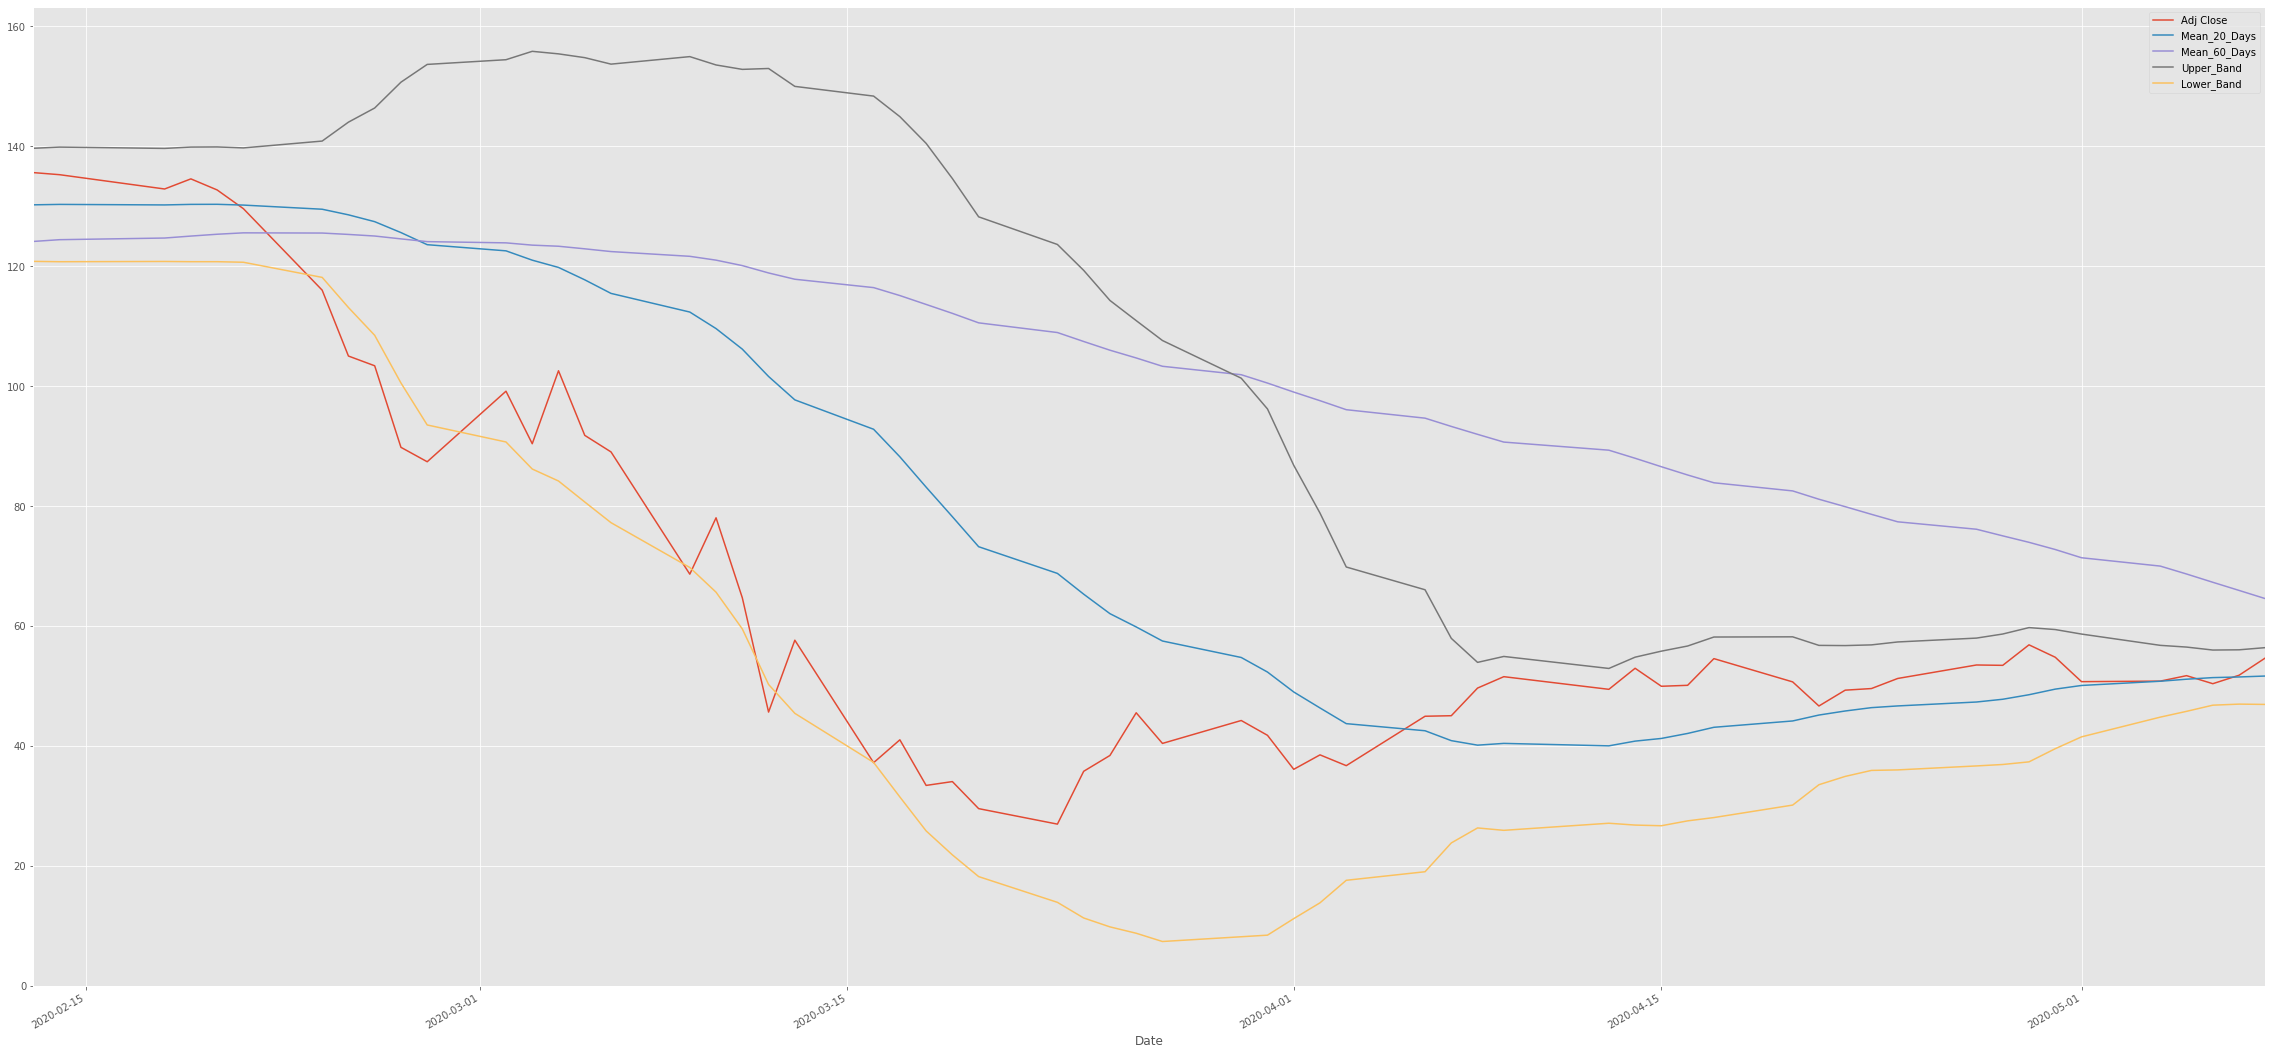

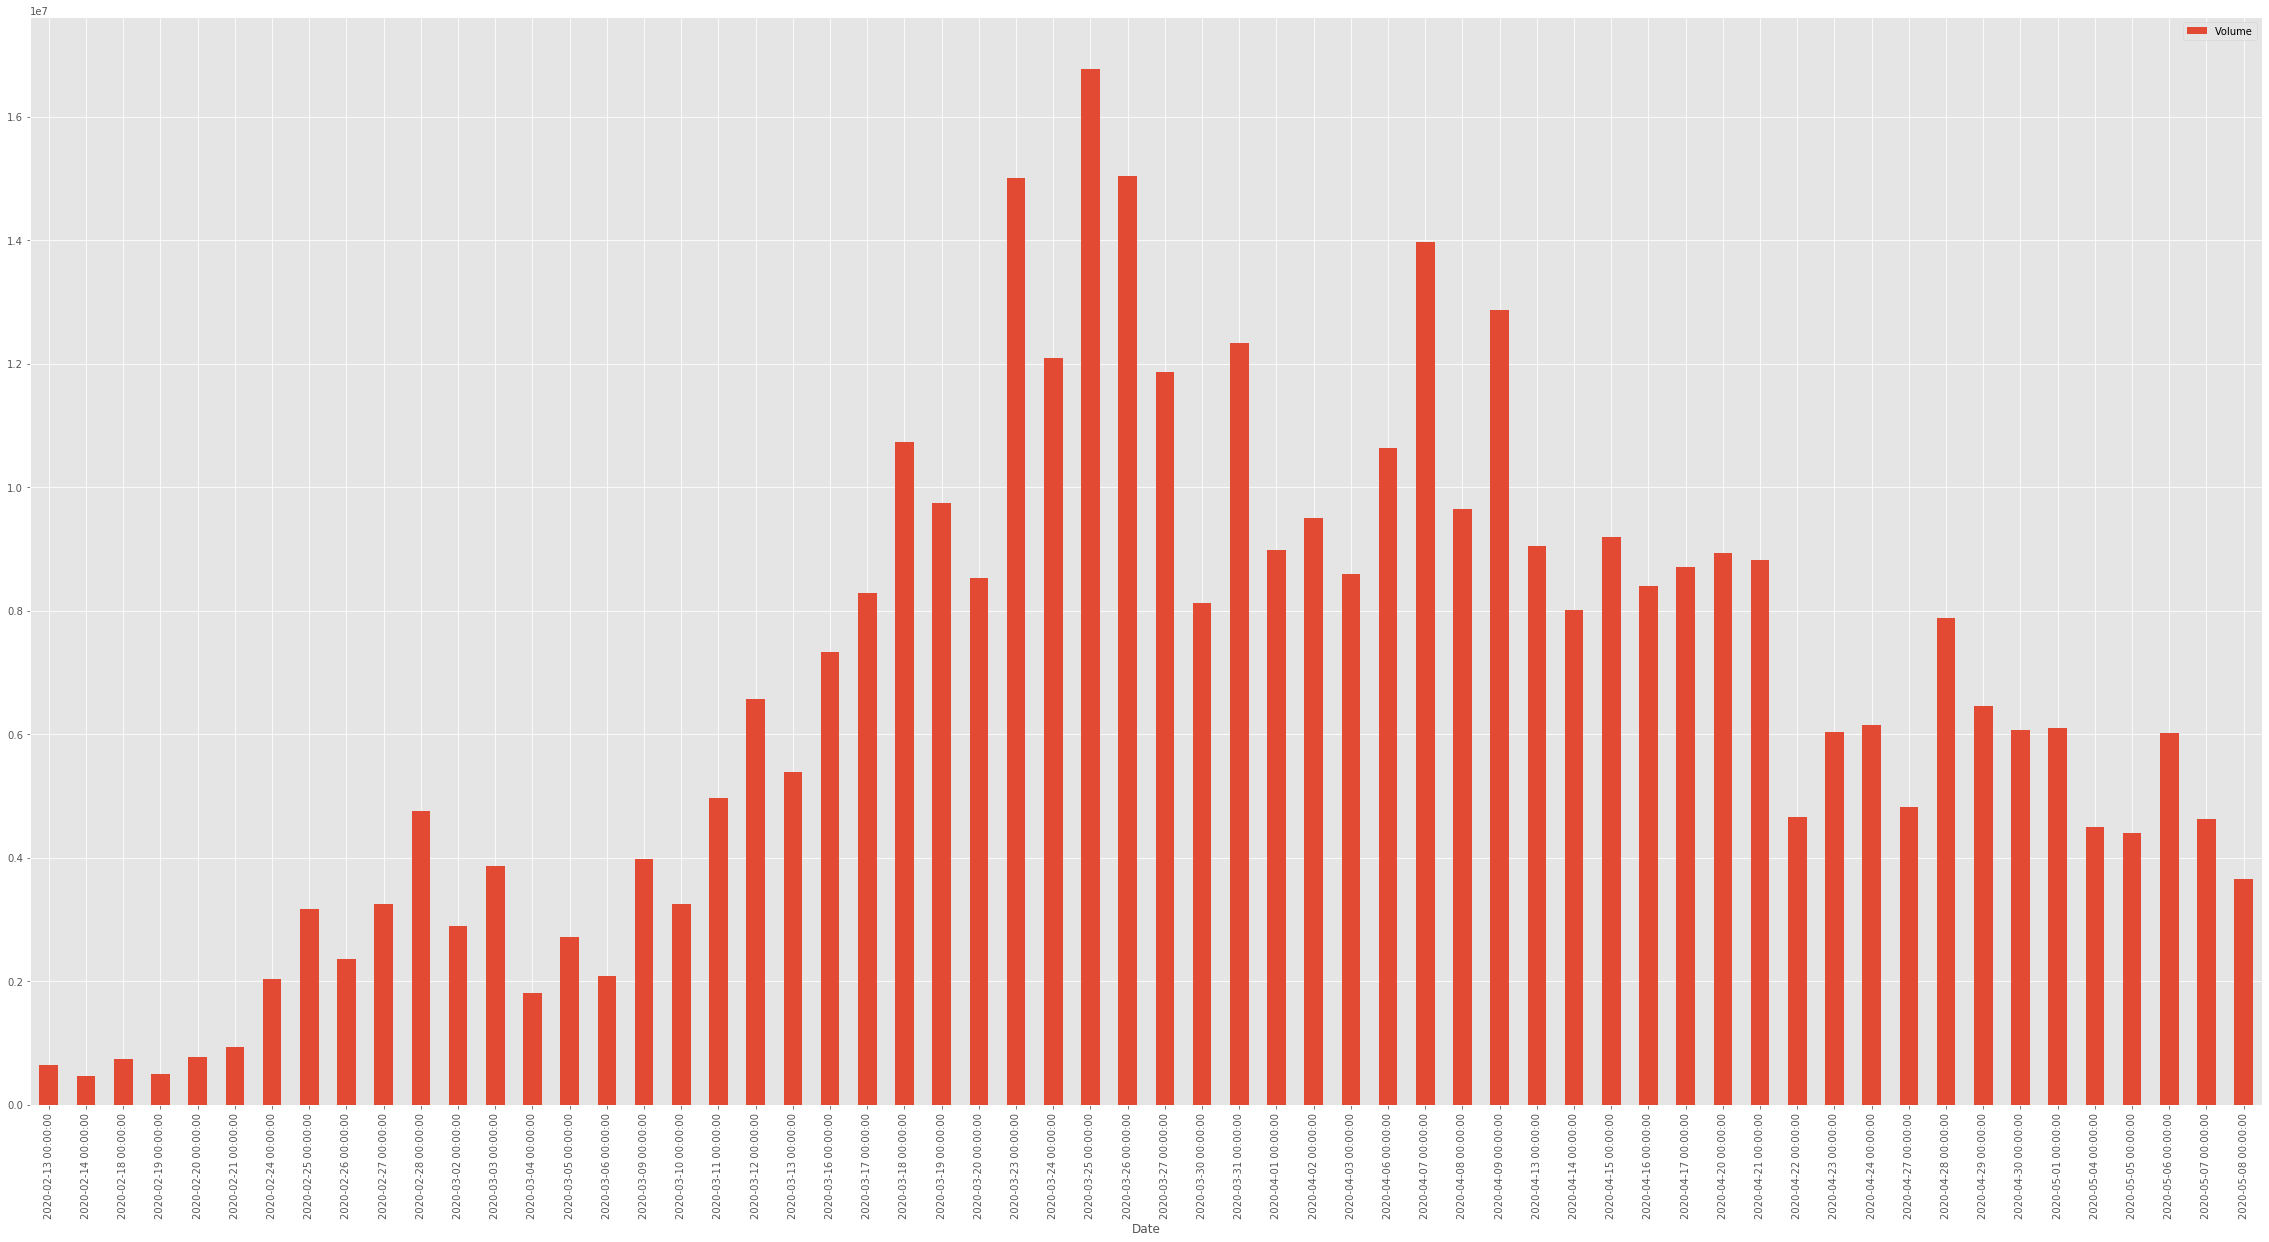

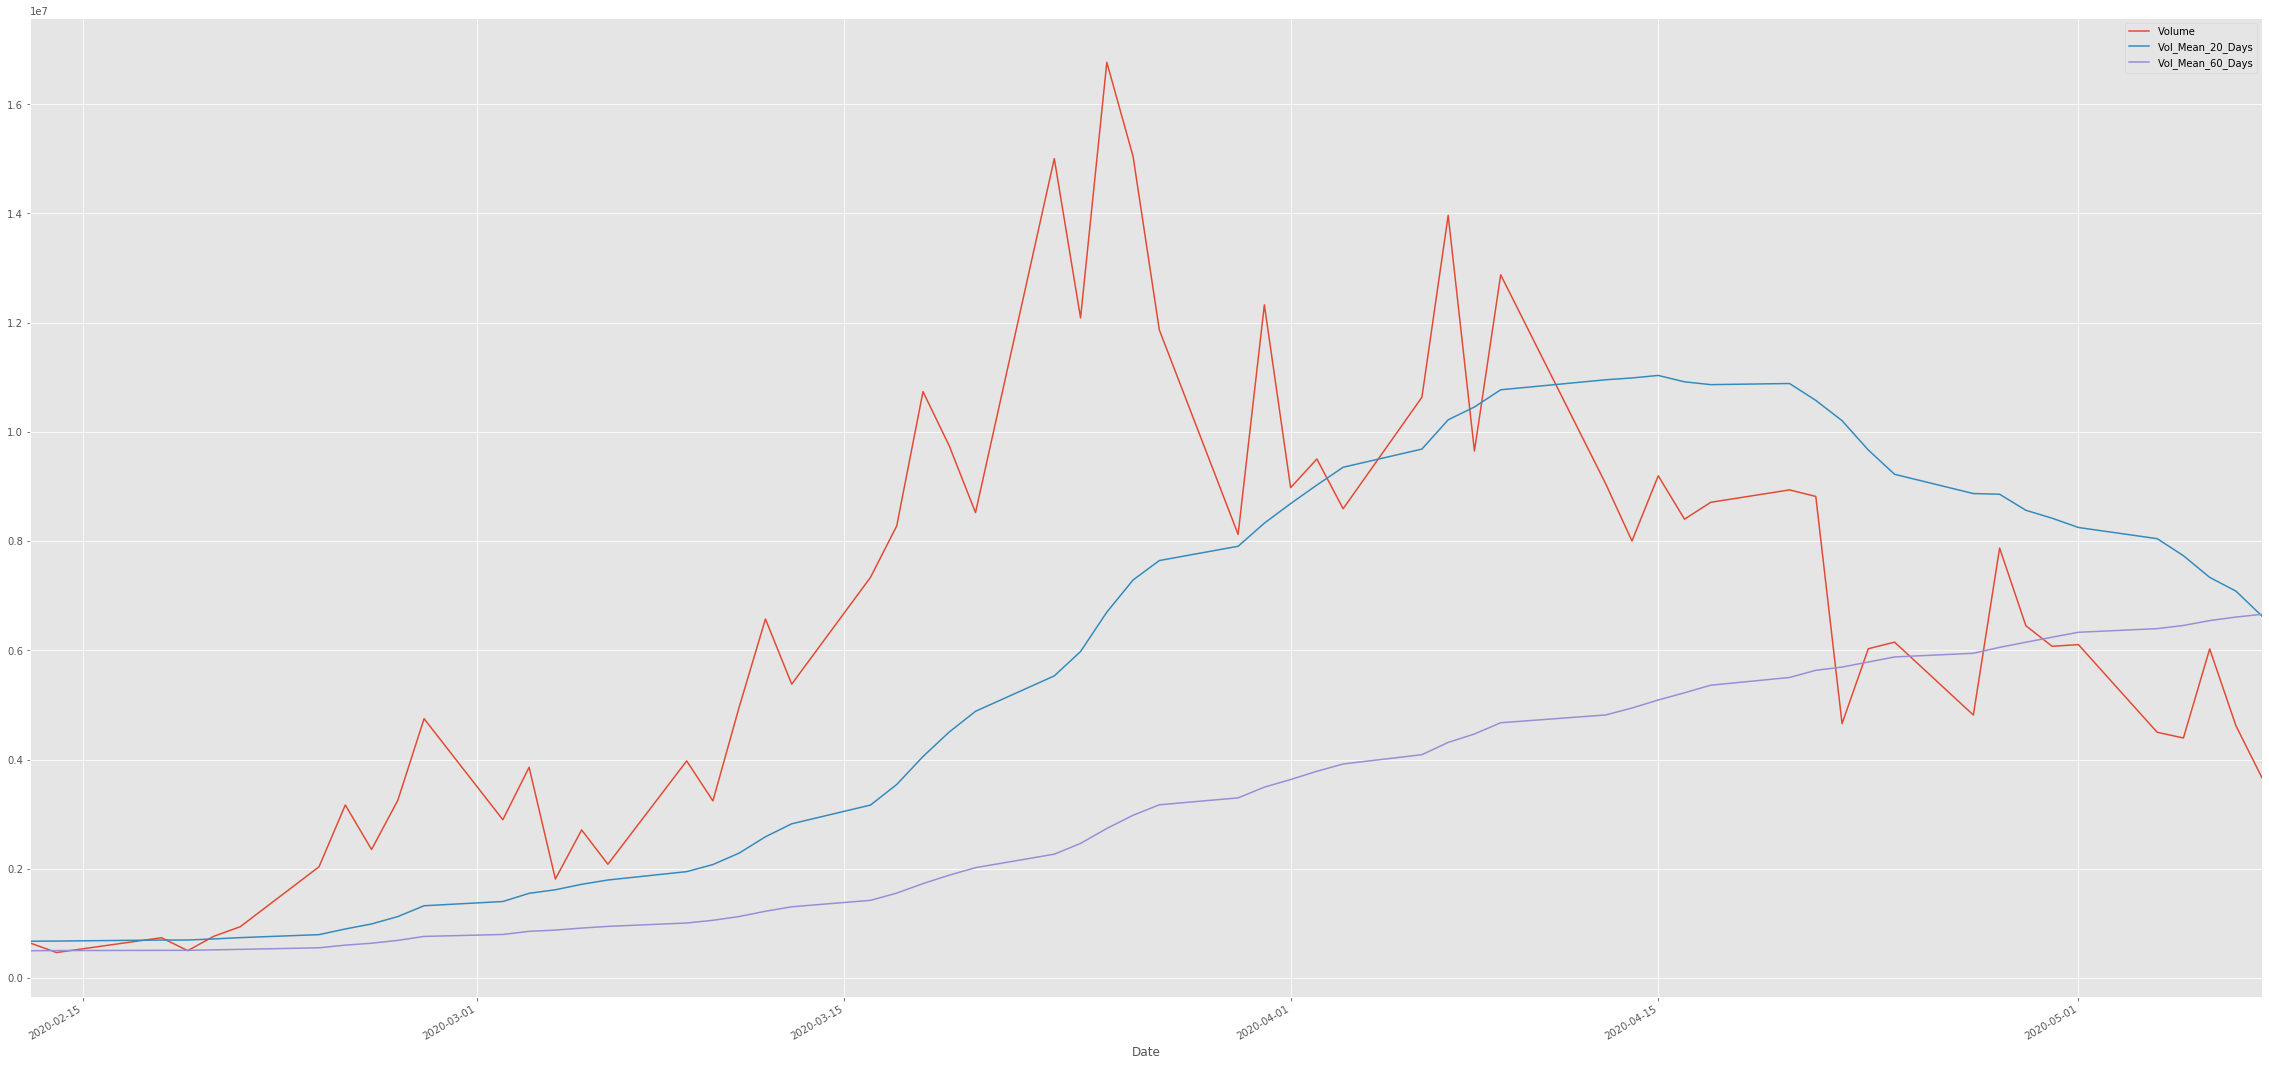

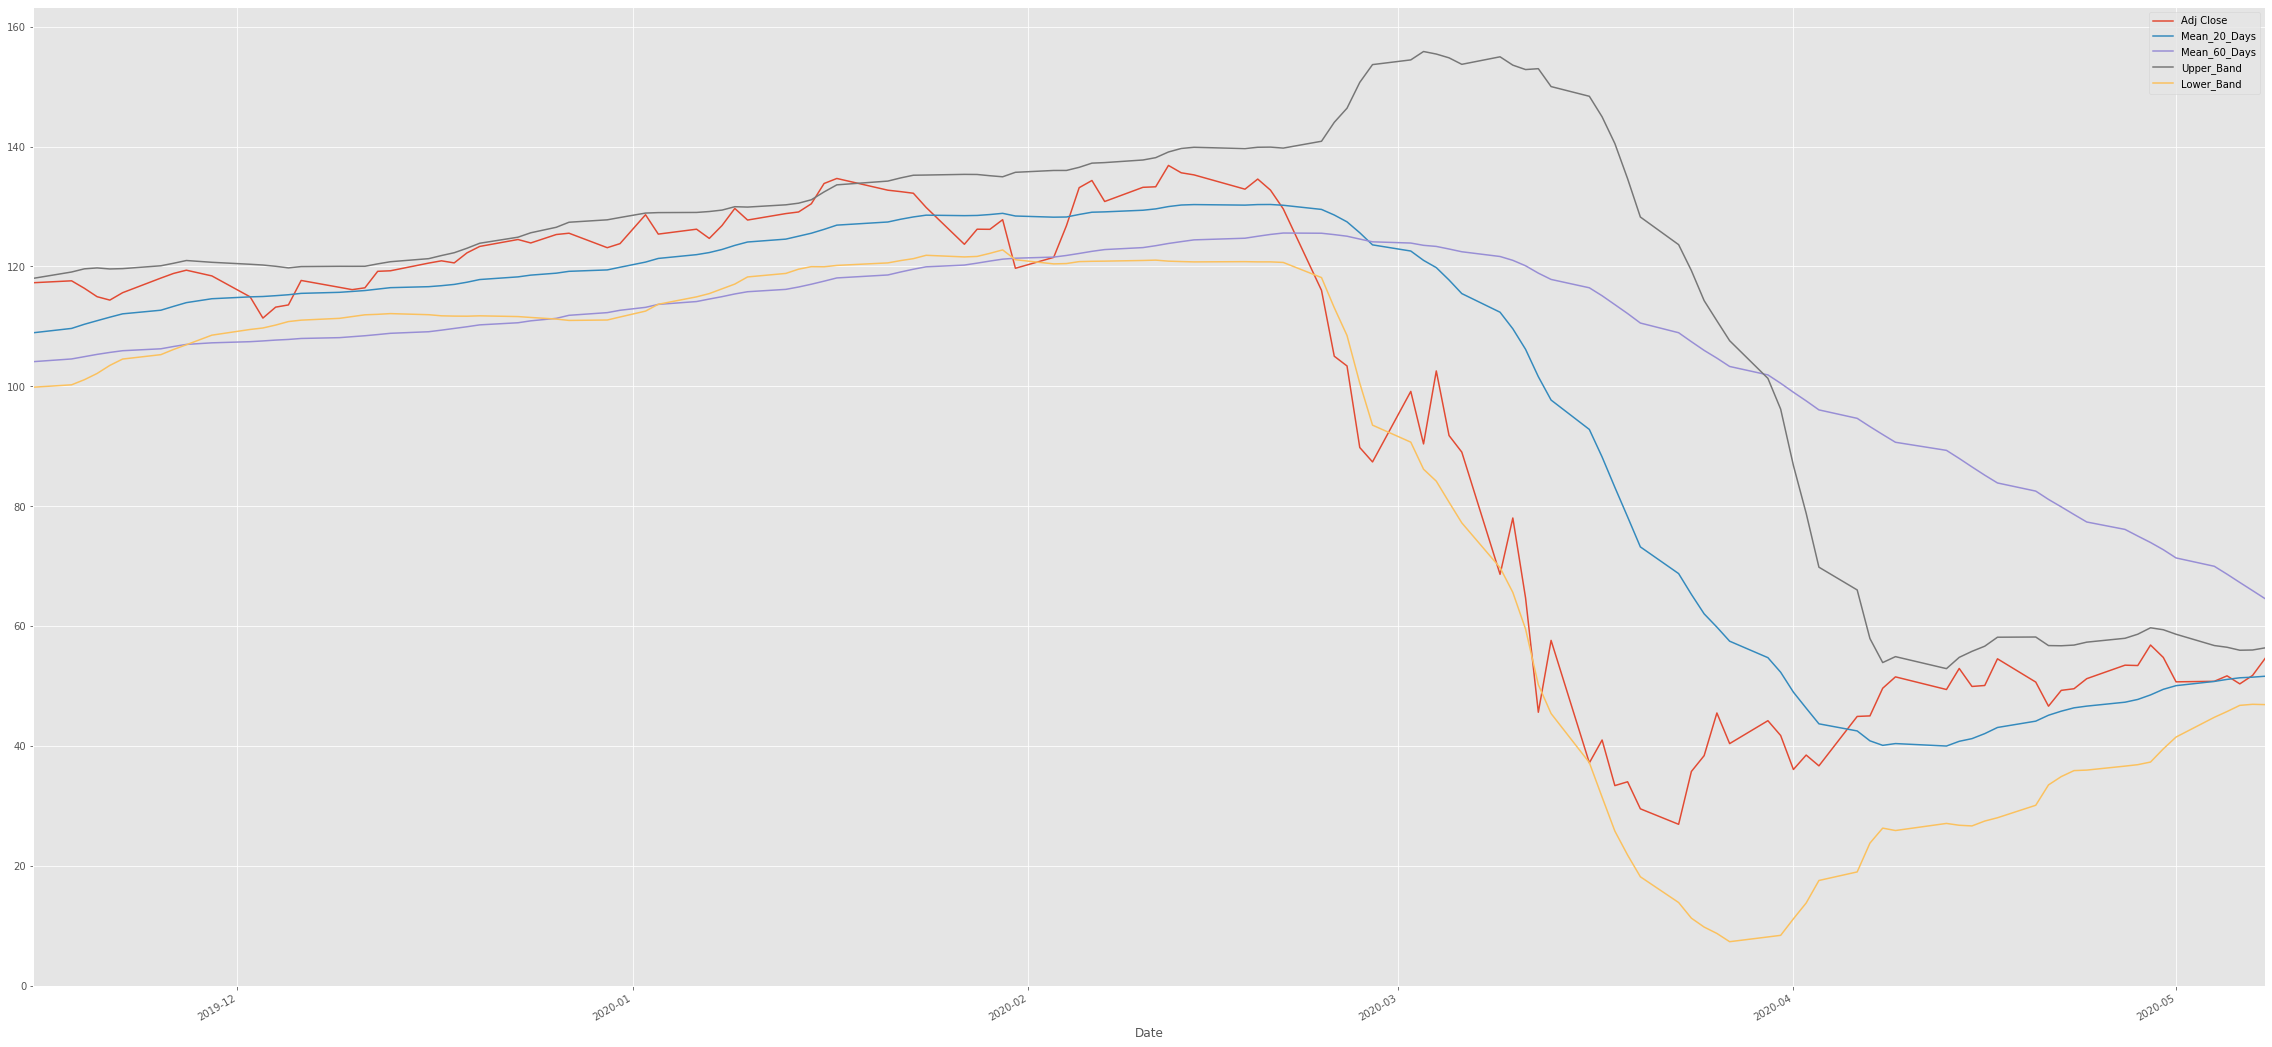

In [98]:
tecl.show_price_trend(60)
tecl.show_volume_trend(60)
tecl.show_price_trend(120)

### 



In [74]:
prior_date_data

,High,Low,Open,Close,Volume,Adj Close,Mean_20_Days,Mean_60_Days,Upper_Band,Lower_Band,Vol_Mean_20_Days,Vol_Mean_60_Days
Date,,,,,,,,,,,,
2020-05-08,178.5,172.619995,176.270004,178.5,827500.0,178.5,151.1985,168.310963,175.334343,127.062657,697835.0,951526.666667


In [ ]:
avg_20 = prior_date_data.iloc[0]['Mean_20_Days']
        avg_60 = prior_date_data.iloc[0]['Mean_60_Days']
        upper = prior_date_data.iloc[0]['Upper_Band']
        lower = prior_date_data.iloc[0]['Lower_Band']
        volume = prior_date_data.iloc[0]['Volume']
        volume_avg_20 = prior_date_data.iloc[0]['Vol_Mean_20_Days']
        volume_avg_60 = prior_date_data.iloc[0]['Vol_Mean_60_Days']        
        if(adj_close>=upper):
            trade_signal = trade_signal+1
        if(adj_close<=lower):
            trade_signal = trade_signal-1
        if(adj_close>avg_20):
            trade_signal = trade_signal+1
        if(adj_close<avg_20):
            trade_signal = trade_signal-1
        if(adj_close>avg_60):
            trade_signal = trade_signal+1
        if(adj_close<avg_60):
            trade_signal = trade_signal-1
        if(trade_signal>0 and   volume < volume_avg_20  and (volume_avg_20 - volume)/volume_avg_20>0.2):
            trade_signal = trade_signal+1
        if(trade_signal>0 and   volume < volume_avg_60  and (volume_avg_60 - volume)/volume_avg_60>0.2):
            trade_signal = trade_signal+1   
        if(trade_signal<0 and   volume < volume_avg_20  and (volume_avg_20 - volume)/volume_avg_20>0.2):
            trade_signal = trade_signal-1
        if(trade_signal<0 and   volume < volume_avg_60  and (volume_avg_60 - volume)/volume_avg_60>0.2):
            trade_signal = trade_signal-1   